# UB DataScience: Complex networks
### David Solans & Gerard Martinez

In [88]:

import networkx as nx
import matplotlib.pyplot as plt
from multiprocessing import Pool
import itertools
from networkx.algorithms import community
import collections
import numpy as np
import pickle
import operator

%matplotlib inline

## Loading data

In [3]:
G = nx.read_edgelist("barcelona_transport.edgelist", create_using = nx.Graph(), nodetype = int)
G_bus = nx.read_edgelist("barcelona_bus.edgelist", create_using = nx.Graph(), nodetype = int)
G_metro = nx.read_edgelist("barcelona_metro.edgelist", create_using = nx.Graph(), nodetype = int)

In [13]:
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [11]:
#Quick snapshot of the Network
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 2497
Number of edges: 3296
Average degree:   2.6400


In [5]:
#Quick snapshot of the Network
print(nx.info(G_bus))

Name: 
Type: Graph
Number of nodes: 2469
Number of edges: 3127
Average degree:   2.5330


In [6]:
#Quick snapshot of the Network
print(nx.info(G_metro))

Name: 
Type: Graph
Number of nodes: 156
Number of edges: 169
Average degree:   2.1667


### Selected network: BUS

We've selected the bus network because it's large enough and it's not conected to the metro network in the source where the data is obtained from

## Exploratory Data Analysis

In [19]:
nodes = list(G_bus.nodes())

In [86]:
bus_stations_properties = load_obj("bus_stations_properties")

In [111]:
bus_stops_coords = []
bus_stops_coords_lats = []
bus_stops_coords_lngs = []
for bs in bus_stations_properties.values():
    bus_stops_coords.append([bs['lat'], bs['lon']])
    bus_stops_coords_lats.append(bs['lat'])
    bus_stops_coords_lngs.append(bs['lon'])

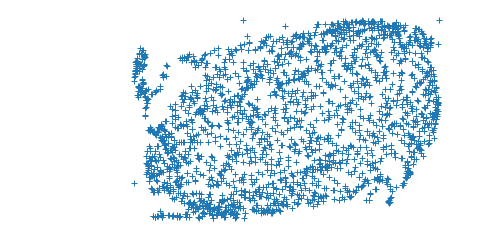

In [117]:
## Plotting the network
plt.axis("off")
plt.plot(bus_stops_coords_lngs, bus_stops_coords_lats, '+')
plt.show()

In [32]:
def plotNetwork(G, node_categories, colormap="jet", pos=None):
    plt.axis("off")
    if pos == None:
        pos = spring_pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos = pos, cmap = plt.get_cmap(colormap), node_color = node_categories, node_size = 35, with_labels = False)

In [33]:
#Create network layout for visualizations
spring_pos = nx.spring_layout(G_bus)

In [116]:
spring_pos

{1788: array([-0.11211328,  0.38860995]),
 274: array([-0.07805475,  0.39075661]),
 3286: array([-0.11855226,  0.32379073]),
 273: array([-0.10758533,  0.35510075]),
 1284: array([-0.12976778,  0.46883398]),
 1286: array([-0.11882173,  0.44553137]),
 1281: array([-0.02595354,  0.32784805]),
 1285: array([-0.04884988,  0.29275945]),
 1282: array([-0.1951306 ,  0.50296003]),
 1604: array([-0.25546265,  0.46874499]),
 954: array([-0.28832152,  0.38842243]),
 955: array([-0.29174045,  0.29123572]),
 959: array([-0.31780785,  0.35364377]),
 1164: array([-0.20337707,  0.26211491]),
 1783: array([-0.34796268,  0.1985577 ]),
 255: array([-0.08746216,  0.33413717]),
 1382: array([-0.25201264,  0.14260896]),
 256: array([0.0323945 , 0.37715614]),
 257: array([0.14750192, 0.38946384]),
 2617: array([0.18168153, 0.34681404]),
 1289: array([0.23455669, 0.40816063]),
 1326: array([0.19125912, 0.3938854 ]),
 1325: array([0.16703886, 0.25803068]),
 1004: array([0.20950344, 0.34685475]),
 2243: array([

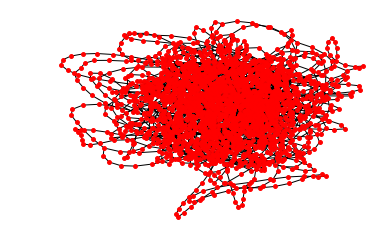

In [119]:
#To be checke for drawing: https://stackoverflow.com/questions/32488772/drawing-nodes-with-coordinates-in-correct-position-using-networkx-matplotlib
plt.axis("off")
nx.draw_networkx(G_bus, pos = spring_pos, with_labels = False, node_size = 15)

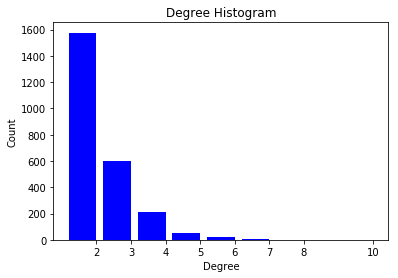

In [35]:
# Nodes degree histogram
degree_sequence = sorted([d for n, d in G_bus.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
plt.show()

In [36]:
# Degree per node
nodes_degrees = [0]*len(nodes)
for idx, n in enumerate(nodes):
    nodes_degrees [idx] = G_bus.degree(n)

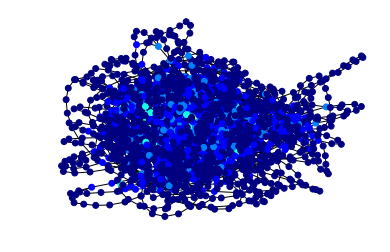

In [37]:
plotNetwork(G_bus, nodes_degrees)

In [39]:
# Average separation of nodes for transport graph
node_distances = []
for g in nx.connected_component_subgraphs(G): 
    node_distances.append(nx.average_shortest_path_length(g)) 

    
print("Average separation of nodes: {}".format(np.mean(node_distances)))

Average separation of nodes: 8.72475195847366


In [40]:
# Average separation of nodes in metro
node_distances_metro = []
for g in nx.connected_component_subgraphs(G_metro): 
    node_distances_metro.append(nx.average_shortest_path_length(g)) 

    
print("Average separation of nodes in metro network: {}".format(np.mean(node_distances_metro)))

Average separation of nodes in metro network: 6.405542040656544


In [41]:
# Average separation of nodes in bus
node_distances_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_distances_bus.append(nx.average_shortest_path_length(g)) 

    
print("Average separation of nodes in bus network: {}".format(np.mean(node_distances_bus)))

Average separation of nodes in bus network: 9.731034826202404


## Adjacency matrix

In [61]:
adjacency_matrix = nx.adjacency_matrix(G_bus, nodelist=None, weight='weight')

Largest eigenvalue: 3.8150509740283436
Smallest eigenvalue: -3.6549942785830924


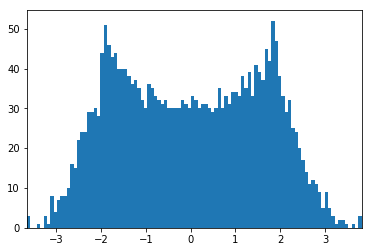

In [70]:
e = np.linalg.eigvals(adjacency_matrix.A)
print("Largest eigenvalue:", max(e))
print("Smallest eigenvalue:", min(e))
plt.hist(e, bins=100)  # histogram with 100 bins
plt.xlim(min(e), max(e))  # eigenvalues between min and max
plt.show()

## Laplacian matrix

Largest eigenvalue: 11.27333342985515
Smallest eigenvalue: -1.0756178287485242e-14


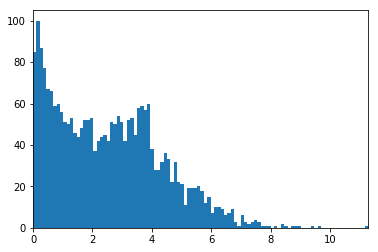

In [83]:
#laplacian_matrix = nx.laplacian_matrix(G_bus, nodelist=None, weight='weight')
#np.linalg.eig(laplacian_matrix.to_numpy_matrix())

laplacian_matrix = nx.laplacian_matrix(G_bus)
e = np.linalg.eigvals(laplacian_matrix.A)
print("Largest eigenvalue:", max(e))
print("Smallest eigenvalue:", min(e))
plt.hist(e, bins=100)  # histogram with 100 bins
plt.xlim(min(e), max(e))  # eigenvalues between min and max
plt.show()

## Centralities

In [66]:
#Degree centrality
degree_centrality = nx.degree_centrality(G_bus)

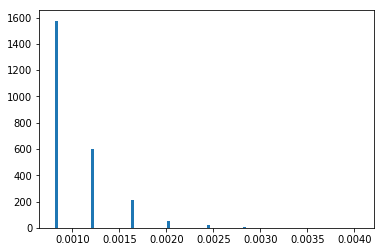

In [71]:
plt.hist(degree_centrality.values(), bins=100)  # histogram with 100 bins
plt.show()

In [98]:
max_degree_central_station = max(degree_centrality.items(), key=operator.itemgetter(1))
print(max_degree_central_station)
bus_stations_properties[max_degree_central_station[0]]

(777, 0.004051863857374392)


{'buses': '30 - 32 - 43 - 44 - 78 - 115',
 'city': 'BARCELONA',
 'furniture': 'Pal',
 'id': '777',
 'lat': '41.3805139',
 'lon': '2.1436483',
 'street_name': 'Av de Roma-Tarragona',
 'utm_x': '428486,2180',
 'utm_y': '4581552,6000'}

In [123]:
eigenvector_centrality = nx.eigenvector_centrality(G_bus, max_iter=10000, tol=1e-06, nstart=None, weight='weight')

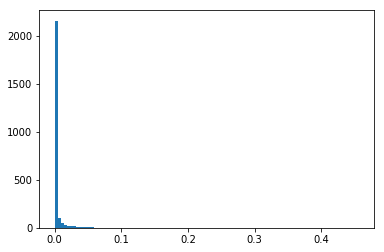

In [73]:
plt.hist(eigenvector_centrality.values(), bins=100)  # histogram with 100 bins
plt.show()

In [96]:
max_eigenvector_central_station = max(eigenvector_centrality.items(), key=operator.itemgetter(1))
print(max_eigenvector_central_station)
bus_stations_properties[max_eigenvector_central_station[0]]

(777, 0.456765123389888)


{'buses': '30 - 32 - 43 - 44 - 78 - 115',
 'city': 'BARCELONA',
 'furniture': 'Pal',
 'id': '777',
 'lat': '41.3805139',
 'lon': '2.1436483',
 'street_name': 'Av de Roma-Tarragona',
 'utm_x': '428486,2180',
 'utm_y': '4581552,6000'}

In [124]:
closeness_centrality = nx.closeness_centrality(G_bus)

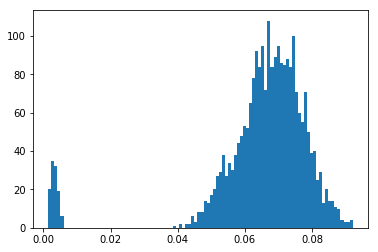

In [125]:
plt.hist(closeness_centrality.values(), bins=100)  # histogram with 100 bins
plt.show()

In [126]:
max_closeness_central_station = max(closeness_centrality.items(), key=operator.itemgetter(1))
print(max_closeness_central_station)
bus_stations_properties[max_closeness_central_station[0]]

(1209, 0.09206609595246185)


{'buses': '07 - 50 - 54 - 56 - 62 - 66 - 67 - 68',
 'city': 'BARCELONA',
 'furniture': 'Pal',
 'id': '1209',
 'lat': '41.3879730',
 'lon': '2.1664645',
 'street_name': 'Gran Via-Rambla Catalunya',
 'utm_x': '430401,3760',
 'utm_y': '4582362,7230'}

In [127]:
betweenness_centrality_source = nx.betweenness_centrality_source(G_bus)

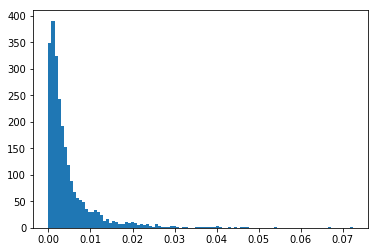

In [128]:
plt.hist(betweenness_centrality_source.values(), bins=100)  # histogram with 100 bins
plt.show()

In [129]:
max_betweeness_central_station = max(betweenness_centrality_source.items(), key=operator.itemgetter(1))
print(max_betweeness_central_station)
bus_stations_properties[max_betweeness_central_station[0]]

(21, 0.07239136501852589)


{'buses': '07 - 33 - 67 - 74 - 75 - 113 - L14 - N12 - L79',
 'city': 'BARCELONA',
 'furniture': 'Marquesina',
 'id': '21',
 'lat': '41.3856356',
 'lon': '2.1161664',
 'street_name': 'Av Diagonal-Palau Reial',
 'utm_x': '426194,0333',
 'utm_y': '4582144,2737'}

### Parallel Betweenness Centrality

In [78]:
def partitions(nodes, n):
    "Partitions the nodes into n subsets"
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter,n))
        if not partition:
            return
        yield partition

In [79]:
def btwn_pool(G_tuple):
    return nx.betweenness_centrality_source(*G_tuple)

In [80]:
def between_parallel(G, processes = None):
    p = Pool(processes=processes)
    part_generator = 4*len(p._pool)
    node_partitions = list(partitions(G.nodes(), int(len(G)/part_generator)))
    num_partitions = len(node_partitions)
 
    bet_map = p.map(btwn_pool,
                        zip([G]*num_partitions,
                        [True]*num_partitions,
                        [None]*num_partitions,
                        node_partitions))
 
    bt_c = bet_map[0]
    for bt in bet_map[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

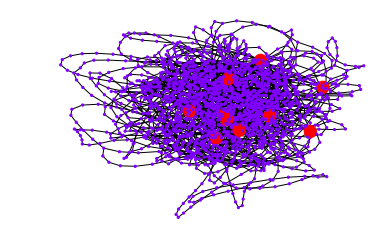

Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Pytho

In [81]:
bt = between_parallel(G_bus)
top = 10

max_nodes =  sorted(bt.items(), key = lambda v: -v[1])[:top]
bt_values = [5]*len(nodes)
bt_colors = [0]*len(nodes)
for max_key, max_val in max_nodes:
    bt_values[max_key] = 150
    bt_colors[max_key] = 2
 
plt.axis("off")
nx.draw_networkx(G_bus, pos = spring_pos, cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False)

## Community Detection

In [45]:
communities_generator = community.girvan_newman(G_bus)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
parts = sorted(map(sorted, next_level_communities))

In [46]:
node_communities = [0]*len(nodes)
for idx,c in enumerate(parts):
    for n in c:
        node_communities[nodes.index(n)] = idx
     

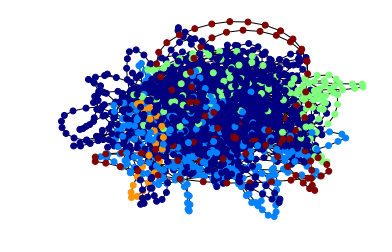

In [47]:
plotNetwork(G_bus,node_communities)

In [21]:
help(community)

Help on package networkx.algorithms.community in networkx.algorithms:

NAME
    networkx.algorithms.community - Functions for computing and measuring community structure.

DESCRIPTION
    The functions in this class are not imported into the top-level
    :mod:`networkx` namespace. You can access these functions by importing
    the :mod:`networkx.algorithms.community` module, then accessing the
    functions as attributes of ``community``. For example::
    
        >>> import networkx as nx
        >>> from networkx.algorithms import community
        >>> G = nx.barbell_graph(5, 1)
        >>> communities_generator = community.girvan_newman(G)
        >>> top_level_communities = next(communities_generator)
        >>> next_level_communities = next(communities_generator)
        >>> sorted(map(sorted, next_level_communities))
        [[0, 1, 2, 3, 4], [5], [6, 7, 8, 9, 10]]

PACKAGE CONTENTS
    asyn_fluidc
    centrality
    community_generators
    community_utils
    kclique
    ke